In [1]:
"""Uses the splines method to identify problem points before interpolation"""

# Package imports
import numpy as np
import statsmodels.api as sm
import os
import pandas as pd
import proplot as pplt
import sys
from scipy.spatial.distance import cdist
sys.path.append('../../drifter/')
import utilities.cleaning as clean
import utilities.interpolation as interp

from importlib import reload
clean = reload(clean)
interp = reload(interp)

/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Folder with the drift tracks from 
# the Arctic Data Center (Bliss et al. 2021)
# https://arcticdata.io/catalog/view/urn%3Auuid%3A2b859a39-cada-4147-819a-dc222f6f89a3
dataloc = '../../data/adc_dn_tracks/'
saveloc = '../data/mosaic_interpolated/'
# Maximum gap in hours for the interpolation algorithm
max_dt = 2

# Pad for interpolation, so that the first and last values aren't missing.
margin = pd.to_timedelta('6H')
buoy_data = {}


# Optional: focus in on only a portion of the tracks
begin = '2019-10-15 00:00'
end = '2022-01-01 00:00'

# Read in the files, including the metadata file
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']

metadata = pd.read_csv(dataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
    
file_present = np.array([f + '.csv' in files for f in metadata.filename])
metadata = metadata.loc[file_present].copy()
metadata.set_index('Sensor ID', inplace=True)

buoy_data = {}
freq = []
buoys = []
for file in files:
    data = pd.read_csv(dataloc + file, index_col='datetime', parse_dates=True)
    dt = pd.to_timedelta(np.diff(data.index)).median().seconds/3600
    buoy = file.replace('.csv', '').split('_')[-1]
    if np.round(dt,1) <= max_dt:
        buoy_data[buoy] = data.copy()
        freq.append(np.round(dt, 1))
        buoys.append(buoy)
    else:
        print(buoy, dt)

2020P215 3.0
2019I2 3.999722222222222
2020P214 3.0
2020P223 3.0
2019F1 3.0
2020P211 3.0
2020T60 12.0
2019I3 4.000277777777778
2019I1 3.999722222222222
2019P22 3.0
2019T47 12.000555555555556
2020P210 3.0
2019I4 4.0


In [3]:
buoy_freq = pd.Series(freq, buoys)

In [4]:
# Updating the metadata tasks:
# Add columns for min_sample_period (reporting frequency for period with regular reporting) and max_sample_period

In [5]:
# Based on comparison with co-located sites, all the V buoys have time indices offset by 8 hours.
for buoy in ['2019V1', '2019V2', '2019V3', '2019V4', '2019V5']:
    buoy_data[buoy].index = buoy_data[buoy].index - pd.to_timedelta('8H')

In [6]:
# Buoys 2019P112-114 have problems that need to be cleaned individually
buoy_data = {buoy: buoy_data[buoy] for buoy in buoy_data if buoy not in ['2019P112', '2019P113', '2019P114', '2019P119']}

In [7]:
# For very high resolution data, there's a lot of noise in the position


In [8]:
# Check for duplicates and isolated data.
for buoy in buoy_data:
    buoy_data[buoy]['flag_date'] = clean.check_dates(buoy_data[buoy], date_index=True) # Initial pass just looks for negative time steps

    buoy_data[buoy]['flag_gaps'] = clean.check_dates(buoy_data[buoy].where(
                                                buoy_data[buoy]['flag_date']==0),
                                          date_index=True, check_gaps=True,
                                          gap_threshold=np.min([6, 6/buoy_freq[buoy]]), gap_window='12H')    
    num_flagged = sum((buoy_data[buoy]['flag_gaps']==1) & (buoy_data[buoy]['flag_date']==0))
    num_flagged_update = 0
    while num_flagged != num_flagged_update:
        num_flagged = sum((buoy_data[buoy]['flag_gaps']==1) & (buoy_data[buoy]['flag_date']==0))
        buoy_data[buoy]['flag_gaps'] = clean.check_dates(buoy_data[buoy].where(
                                                (buoy_data[buoy]['flag_date']==0) & (buoy_data[buoy]['flag_gaps']==0)),
                                          date_index=True, check_gaps=True,
                                          gap_threshold=np.min([6, 6/buoy_freq[buoy]]), gap_window='12H')    
        num_flagged_update = sum((buoy_data[buoy]['flag_gaps']==1) & (buoy_data[buoy]['flag_date']==0))

    if num_flagged > 0:
        print(buoy, num_flagged)

2019R9 5
2019P142 4
2019R8 1
2019P203 1
2019P151 142
2020P171 1
2020P162 1
2019O4 46
2020S97 5
2019P143 7
2019P137 11
2020P163 5
2020P178 4
2020R10 1
2019O2 1
2019P138 7
2019P140 4
2019P199 1
2019P146 5
2019T56 9
2019P152 461
2019V4 14
2019F3 2
2019P90 4
2019P139 3500
2020T78 1355
2019P88 45
2019V2 184
2020P180 5
2020P168 1
2020P231 7
2019P156 870
2019P196 33
2019S84 4
2019P148 3
2020P227 1
2020P175 30
2019F2 10
2019F4 3
2019P127 1
2019O8 4
2019T69 301
2019P197 21
2019P124 5
2019P159 440
2019P136 440
2019P150 184
2019V1 29
2019P145 4
2020P186 203
2020P185 15
2019P205 16
2019V3 31
2019P101 70
2020P234 85
2019P144 49
2020P213 290
2020R12 2
2019P155 4
2020P219 5
2019P158 99
2020P229 14
2020P237 39


In [28]:
clean = reload(clean)
for buoy in buoy_data:
    buoy_data[buoy]['flag_position'] = clean.check_duplicate_positions(buoy_data[buoy], pairs_only=True)
    n = buoy_data[buoy]['flag_position'].sum()
    if n > 0:
        print(buoy, n)

2020P170 1
2020P171 6
2020P233 3
2019O4 5
2020S97 2
2019S94 3
2020P236 1
2020P220 8
2020O10 33
2019O6 4
2019P125 1
2020P177 8
2019P92 1
2020P228 1
2020P172 1
2019P90 542
2019P102 1200
2020P225 1
2020S108 9
2019S96 1
2020P231 10
2019P156 1
2020P217 10
2019P128 2
2019P157 8
2020P160 2
2019P198 22
2020P175 1
2020P218 11
2020P181 3
2020S106 7
2019P127 1
2020S107 4
2019P136 2
2020S105 8
ASFSTUCB1 1
2020P185 25
2019P205 609
ASFS50UCB1 1
2019P101 1
ASFS30UCB2 4
2019S86 3
2020P234 116
2020P173 1
2019P144 289
2019O1 2
2019P123 1
2020P216 7
2020S98 13
2019P155 2
2020S99 1
2020P219 8
2019O5 3
2019P103 625
2020P237 29


<a list of 1 Line2D objects>

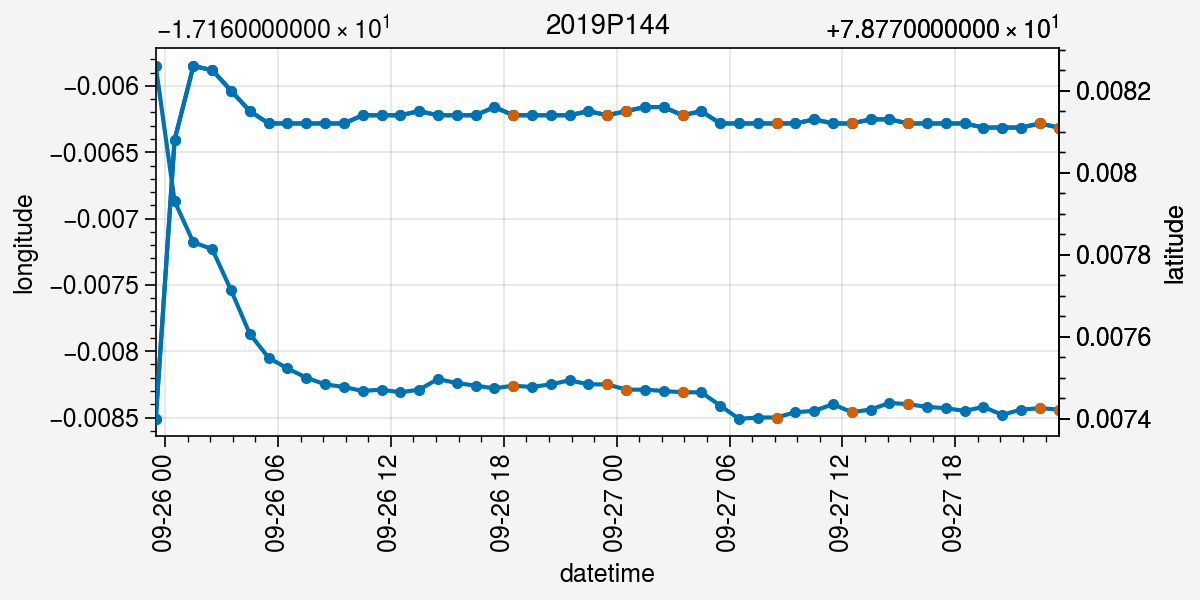

In [31]:
buoy = '2019P144'
margin = pd.to_timedelta('1D')
buoy_df = buoy_data[buoy].copy()
flagged = buoy_df.loc[(buoy_df.flag_position==1) & (buoy_df.flag_date ==0)].index
if len(flagged) == 1:
    date = pd.to_datetime(flagged[0])
else:
    date = pd.to_datetime(flagged[1])

fig, ax = pplt.subplots(width=6, height=3)

buoy_df = buoy_df.loc[slice(date-margin, date+margin)]
threshold = buoy_df.rolling('12H', center=True).longitude.count()
ax.plot(buoy_df.longitude, marker='.')
ax.plot(buoy_df.where(buoy_df.flag_position==1).longitude, marker='.', lw=0)
ax.format(title=buoy)
ax2 = ax.twinx()
ax2.plot(buoy_df.latitude, marker='.')
ax2.plot(buoy_df.where(buoy_df.flag_position==1).latitude, marker='.', lw=0)


# ax2.plot(threshold, marker='.', color='r', alpha=0.2)
# ax2.format(ylabel='Count')

In [93]:
for buoy in buoy_data:
    buoy_data[buoy]['flag'] = buoy_data[buoy].flag_date | buoy_data[buoy].flag_position | buoy_data[buoy].flag_gaps

In [96]:
# Drift speed:
for buoy in buoy_data:
    buoy_df = buoy_data[buoy].where(buoy_data[buoy]['flag'] == 0)
    w_speed = clean.compute_speed(buoy_df.dropna().copy(), date_index=True, difference='forward')
    buoy_df.loc[w_speed.index, 'speed'] = w_speed['speed'].copy()
    buoy_data[buoy] = buoy_df

Because the buoys vary in their time resolution and in the inherent noise, naive screening for fixed velocity thresholds will not identify most spikes in estimated velocities. Furthermore, data at very high resolution (e.g. < 15min) provide noisy estimates of position, because the inherent error in position of between 10-100 m is close to the magnitude of position change. For example, if ice is moving at 0.5 m/s, it moves 450 meters in between measurements. Estimated difference in position will be between 430 and 470 in the best case scenario, and between 350 and 550 in the worst case. For ice moving more slowly, as it often is, the result of the noise could be that the uncertainty in position is larger than the position change. Per Dierking et al. 2022,
$$\sigma^2_u = \frac{1}{\Delta t^2}\sigma_{x}^2$$
With smaller time steps, the uncertainty in velocity is larger (in a sense).

In [311]:
for buoy in buoy_data:
    buoy_data[buoy]['fwd_disp'] = np.sqrt(
        (buoy_data[buoy]['x'].shift(-1) - buoy_data[buoy]['x'])**2 +\
        (buoy_data[buoy]['y'].shift(-1) - buoy_data[buoy]['y'])**2)
    buoy_data[buoy]['bwd_disp'] = np.sqrt(
        (buoy_data[buoy]['x'] - buoy_data[buoy]['x'].shift(1))**2 +\
        (buoy_data[buoy]['y'] - buoy_data[buoy]['y'].shift(1))**2)

    date = buoy_data[buoy].index.to_series()
    time_till_next = date.shift(-1) - date
    time_since_last = date - date.shift(1)
    f = (time_since_last.dt.total_seconds()).rolling('7D', ).median()
    buoy_data[buoy]['fwd_endpoint'] = (time_till_next - time_since_last).dt.total_seconds() > 2*f
    buoy_data[buoy]['bwd_endpoint'] = (time_since_last - time_till_next).dt.total_seconds() > 2*f

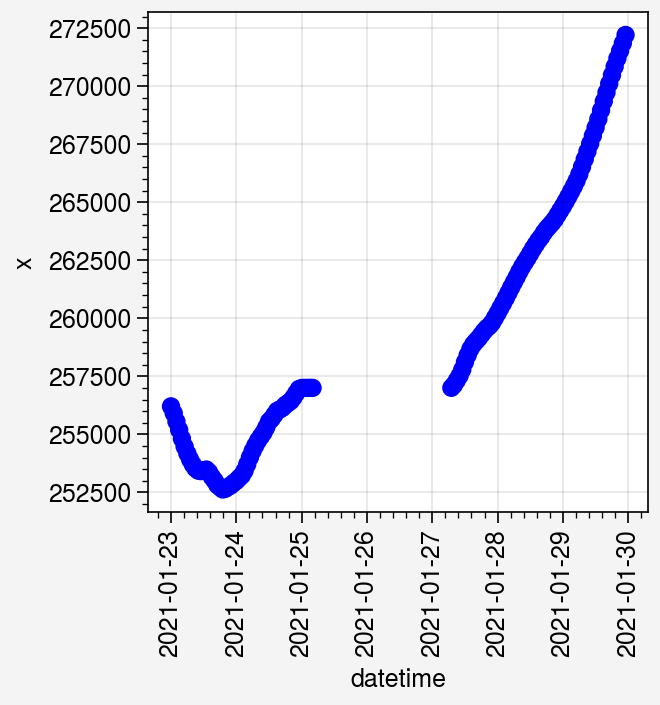

In [316]:
fig, ax = pplt.subplots()
timeslice=slice('2021-01-23', '2021-01-29')
ax.scatter(buoy_data[buoy].x.loc[timeslice], c=buoy_data[buoy]['bwd_endpoint'].loc[timeslice].astype(int), cmap='bwr')

In [222]:
data = []
for buoy in buoy_data:
    x = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['x']
    anomalyx = x - x.rolling(3, center=True, min_periods=3).median()
    buoy_data[buoy]['x_anom'] = anomalyx
    y = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['y']
    anomalyy = y - y.rolling(3, center=True, min_periods=3).median()
    buoy_data[buoy]['y_anom'] = anomalyy
    buoy_data[buoy]['anom_dist'] = np.sqrt(anomalyx**2 + anomalyy**2)

    data.append([buoy, buoy_freq[buoy], anomalyx.max(), (anomalyx > 200).sum() / len(anomalyx),  (anomalyx > 200).sum() ])
df = pd.DataFrame(data, columns=['name', 'f', 'anom_max', 'frac_nonzero', 'n'])

In [240]:
date = buoy_data['2019P142'].index.to_series()
time_till_next = date.shift(-1) - date
time_since_last = date - date.shift(1)

# #buoy_data['2019P142'].tail(100)['x_anom'].plot(marker='.')
# fig, ax = pplt.subplots()
# ax.scatter(buoy_data['2019P142'].tail(100)['x_anom'], c=time_since_last.tail(100).dt.total_seconds())

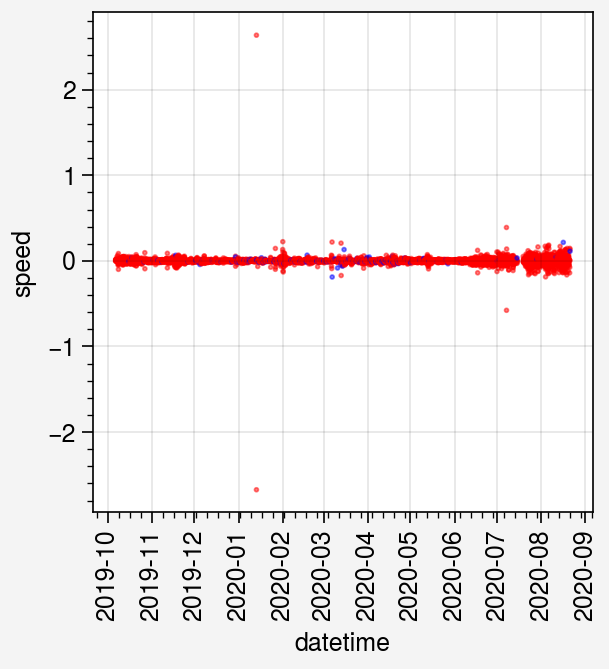

In [289]:
from scipy.stats import linregress
buoy_df = buoy_data['2019P138'].dropna()
date = buoy_df.index.to_series()
time_till_next = date.shift(-1) - date
time_since_last = date - date.shift(1)

#daily_speeds = buoy_df['speed'].resample('1D').mean()
#displacements = np.sqrt((buoy_df['x'] - buoy_df['x'].shift(1))**2 + \
#                        (buoy_df['y'] - buoy_df['y'].shift(1))**2).resample('1D').mean()
#anomalies = buoy_df['anom_dist'].where(buoy_df['anom_dist']>0).resample('1D').mean()
fig, ax = pplt.subplots()
# ax.scatter(daily_speeds, displacements, c=displacements.index.month, colorbar='r', N=12, cmap='spectral')
ax.scatter(buoy_df['speed']-
           buoy_df['speed'].shift(1),
           c=((time_till_next - time_since_last) < threshold).astype(int), cmap='bwr', alpha=0.5, markersize=2)



<AxesSubplot:xlabel='datetime'>

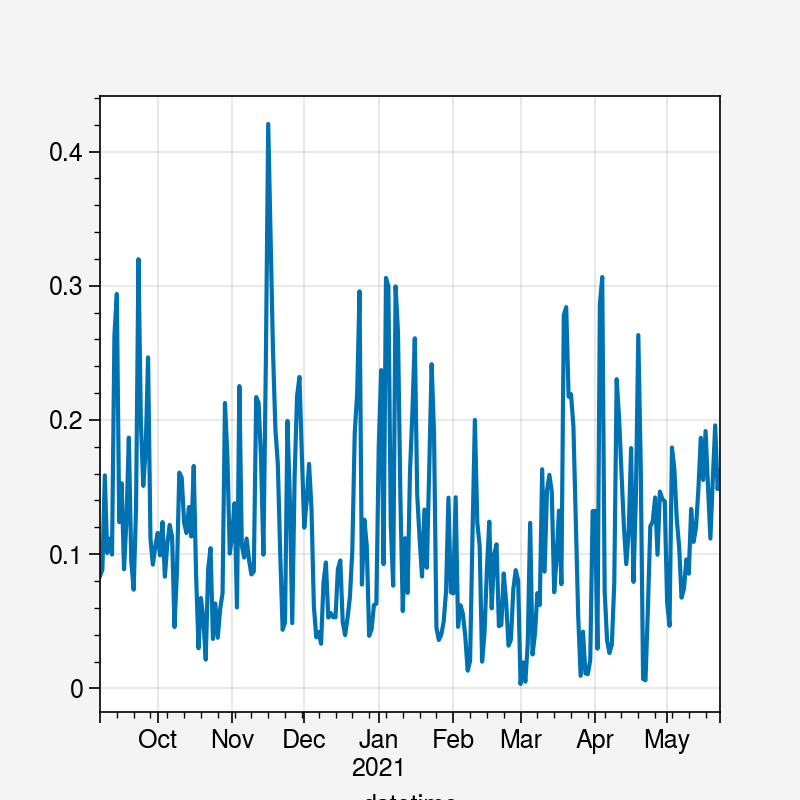

In [254]:
# Average daily displacement and average daily speed are nearly 1-1. This is obvious, since that's
# what speed and displacement essentially are, but is relevant because if we want to know what an anomalies point 
# is, the anomaly is relative to how fast the ice is moving.

In [150]:
test_df = pd.DataFrame(
    [['2019R9', '2020-04-23 11:01:09', 'check_speed', True],
     ['2019R9', '2020-05-17 01:02:20', 'check_speed', True],
     ['2020P171','2020-12-13 00:04:00', 'check_speed', True],
     ['2020P171', '2021-01-08 20:04:01', 'check_speed', True],
     ['2020P171', '2021-01-08 16:04:02', 'check_speed', True],
     ['2019P178', '2021-01-21 13:00:28', 'check_speed', True],
     ['2019P142', '2020-04-04 14:30:00', 'check_speed', True],
     ['2019P142', '2020-05-25 01:00:00', 'check_speed', True], 
      ['2019P142', '2020-07-23 00:59:59', 'check_speed', True]],
    columns=['buoy_id', 'date', 'check_var', 'true_val'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [138]:
date = pd.Series(buoy_data[buoy].index, index=buoy_data[buoy].index)
time_till_next = date.shift(-1) - date
time_since_last = date - date.shift(1)
threshold=pd.to_timedelta('6H')
testable = (time_since_last < threshold) & (time_till_next < threshold)
anomaly.idxmax()

Timestamp('2020-09-29 05:00:01')

In [ ]:
# It's pretty quick to get the anomaly relative to the neighbors.
# What if I do the spline comparison only at places with nonzero anomaly?

In [165]:
var=[]
for buoy in buoy_data:
    anom_x = buoy_data[buoy].x_anom
    anom_y = buoy_data[buoy].y_anom
    anom = np.sqrt(anom_x**2 + anom_y**2)
    var.append(anom[anom > 0].quantile(0.99))

In [169]:
var

[211.92664322958058,
 741.2668577552419,
 30.93007628769847,
 83.85770444918047,
 92.91162519295239,
 87.52793896974742,
 86.87074514345731,
 15.543399186833755,
 108.00030224665343,
 415.9811547564203,
 850.4752571516234,
 3.8873570146528023,
 111.27922905389201,
 109.58782456790146,
 48.327057745914146,
 125.74099361689602,
 24.94870482800524,
 443.13387374019925,
 62.67740876429481,
 796.6814781547974,
 7.569582009500185,
 96.78246911828128,
 24.391151464337028,
 405.66921243308445,
 126.54001374379393,
 1.4166052654458325,
 76.79579023482106,
 487.6644010988024,
 32.19466924453658,
 98.82240587914369,
 142.00459242735624,
 8.419781258420846,
 538.7995566302222,
 163.28936986025656,
 310.7109936038792,
 138.44436072348614,
 11.699788158208221,
 557.0010745462357,
 73.32338553961341,
 35.14649466842641,
 193.14339637039862,
 126.32179807297854,
 27.11695282137365,
 497.78411466016803,
 45.49894575760218,
 467.58955748119035,
 23.76328967306126,
 57.03072542459169,
 515.0551985446917,

<a list of 1 Line2D objects>

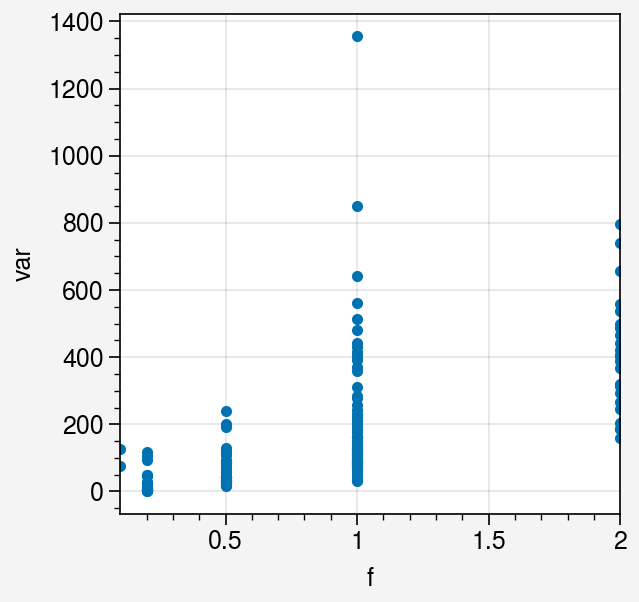

In [172]:
df['var'] = var
fig, ax = pplt.subplots()
ax.plot(df.f, df['var'], marker='.', lw=0)

In [195]:
def spline_check_v2(buoy_df, anom_thresh, df):
    anom_x = buoy_data[buoy].x_anom
    anom_y = buoy_data[buoy].y_anom
    anom = np.sqrt(anom_x**2 + anom_y**2)
    if 'flag_position_spline' not in buoy_df.columns:
        buoy_df['flag_position_spline'] = 0

    for date in anom[anom > anom_thresh].index:
        test = clean.test_point(date, buoy_data[buoy],
                                xvar='x', yvar='y', df=df, fit_window='24H', sigma=6)['flag']
        if np.any(test):
            buoy_df.loc[test[test].index, 'flag_position_spline'] = 1
    
    return buoy_df

In [201]:
test = clean.test_point(date, buoy_df,
                        xvar='x', yvar='y', df=13, fit_window='24H', sigma=6)['flag']
test[test].index


DatetimeIndex(['2021-04-09 12:04:03'], dtype='datetime64[ns]', name='datetime', freq=None)

In [197]:
buoy_df = buoy_data[buoy].copy()
buoy_df = spline_check_v2(buoy_df, 400, 13)
buoy_df.flag_position_spline.sum()

280

DatetimeIndex(['2020-12-13 00:04:00', '2021-01-08 14:04:01',
               '2021-01-08 19:03:59', '2021-01-08 20:04:01',
               '2021-02-10 04:03:59', '2021-02-10 05:04:01',
               '2021-02-18 07:03:04', '2021-02-18 08:04:01',
               '2021-02-18 09:04:03', '2021-03-05 12:04:03',
               '2021-03-05 13:04:04', '2021-05-14 06:04:03',
               '2021-05-14 07:03:22'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [219]:
dates = buoy_df.index[buoy_df.flag_position_spline==1][0:10]

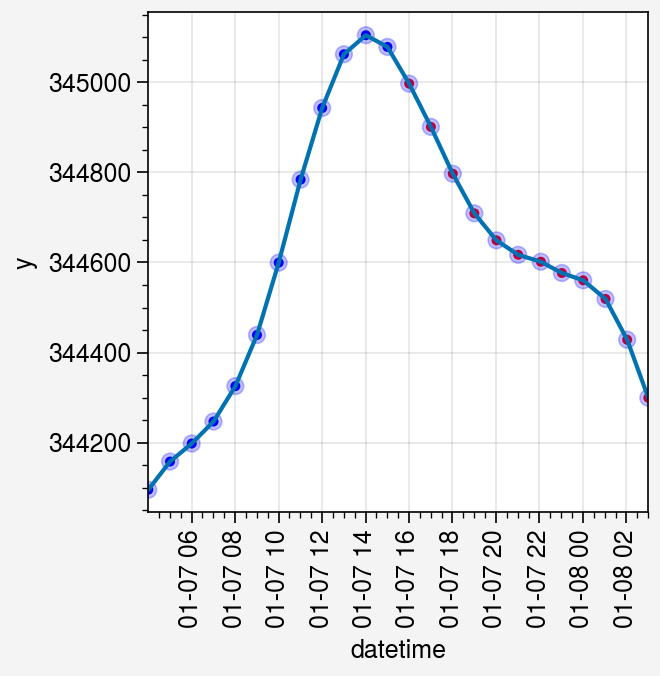

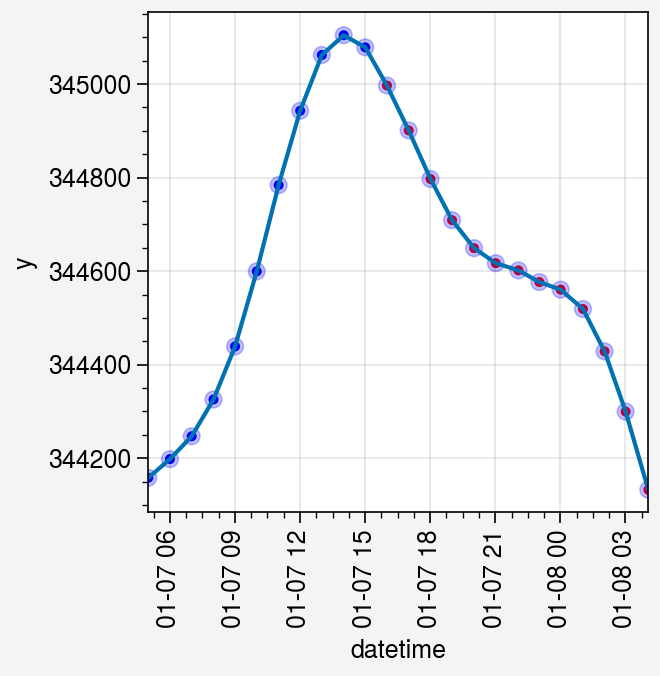

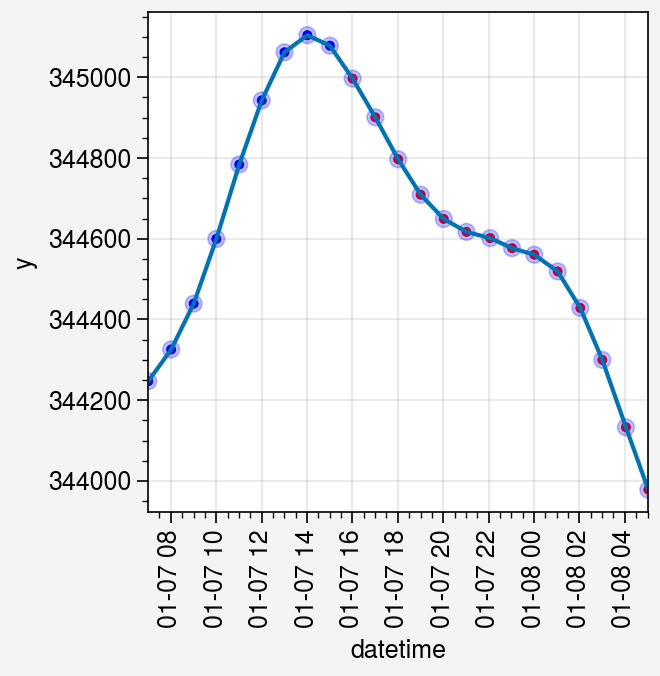

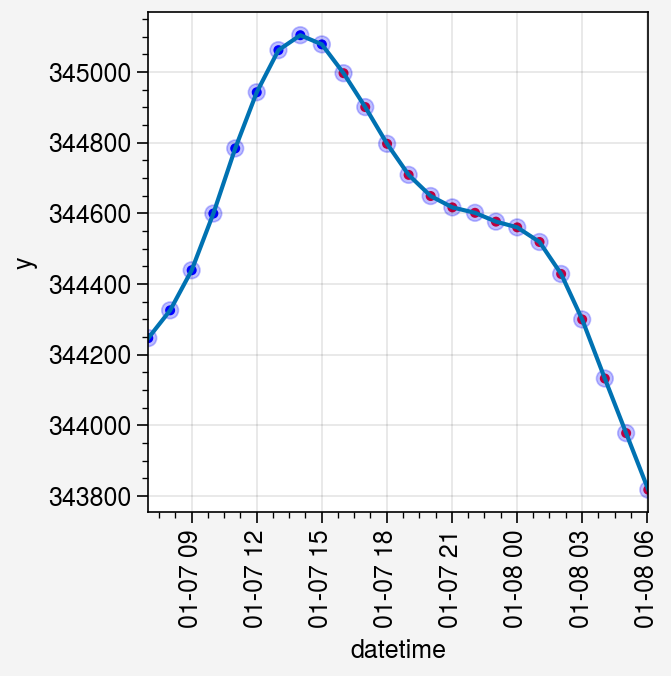

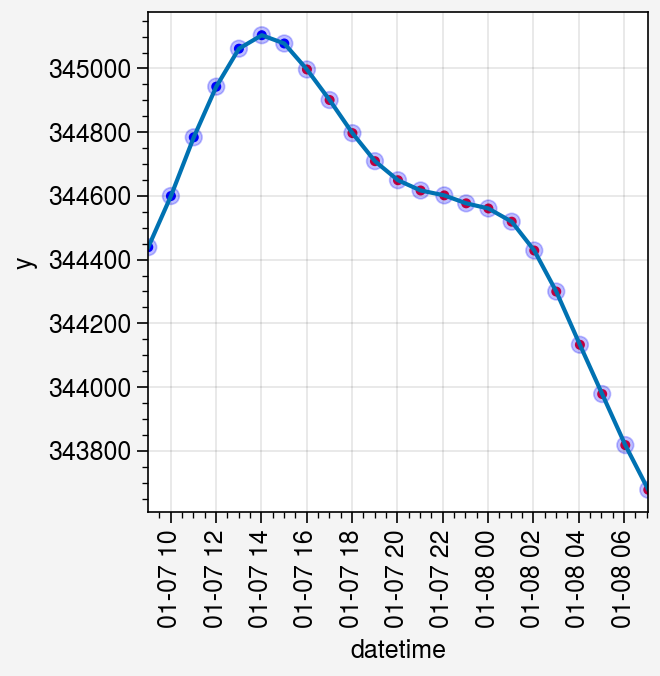

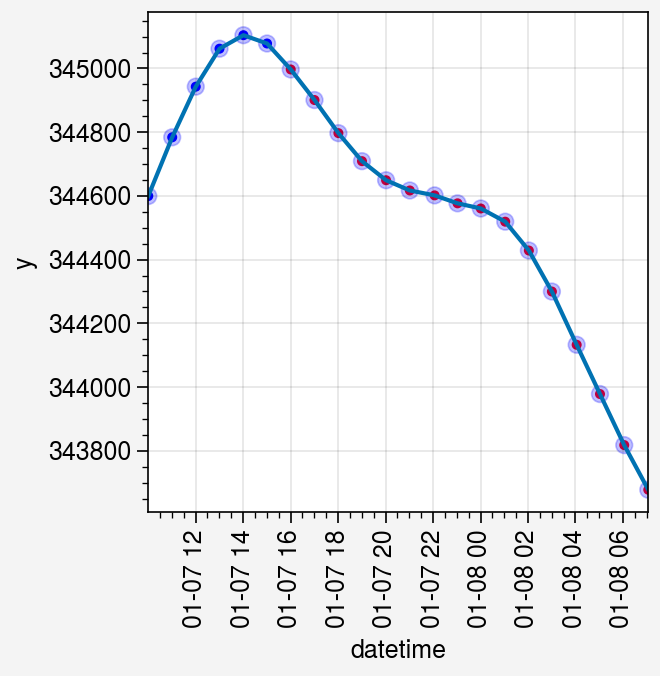

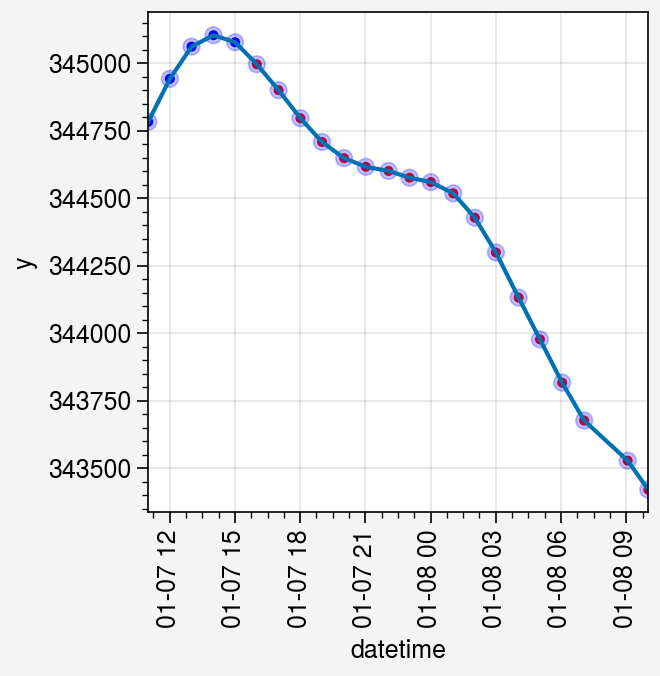

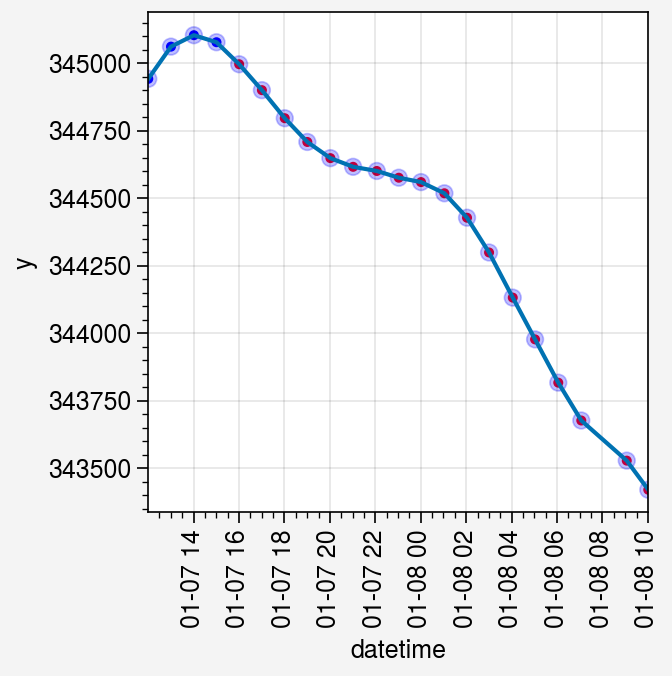

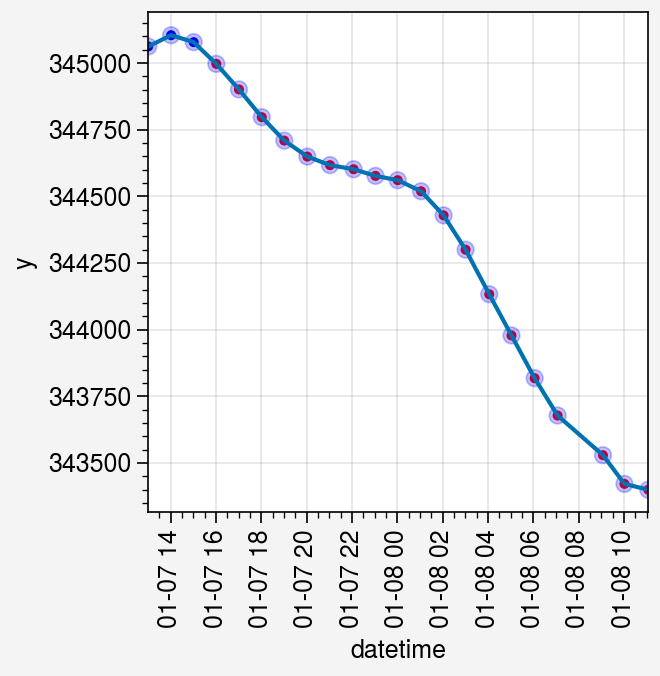

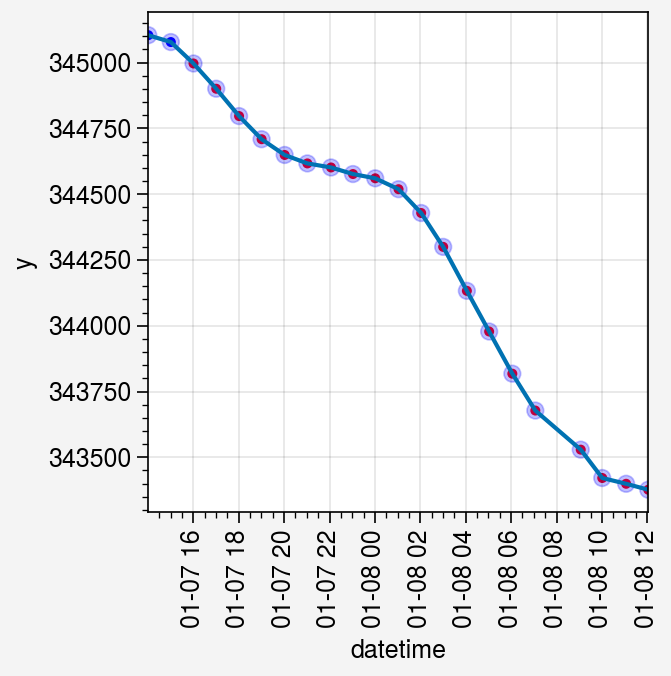

In [220]:
dates = buoy_df.index[np.abs(buoy_df['y_anom']) > 200]
for date in dates:
    timeslice = slice(date - margin, date + margin)
    fig, ax = pplt.subplots()
    ax.plot(buoy_df['y'].loc[timeslice])
    ax.scatter(buoy_df['y'].loc[timeslice],
               c=buoy_df['flag_position_spline'].loc[timeslice], marker='.', cmap='bwr')
    ax.scatter(buoy_df['y'].loc[timeslice],
               c=(np.abs(buoy_df['y_anom']) > 200).loc[timeslice], marker='o', cmap='bwr', alpha=0.25)

DatetimeIndex(['2021-01-08 15:04:03', '2021-01-08 16:04:02',
               '2021-01-08 19:03:59', '2021-01-08 20:04:01',
               '2021-02-10 04:03:59', '2021-02-10 05:04:01',
               '2021-02-18 08:04:01', '2021-03-05 12:04:03',
               '2021-03-05 13:04:04', '2021-03-30 08:04:01',
               '2021-04-09 12:04:03'],
              dtype='datetime64[ns]', name='datetime', freq=None)


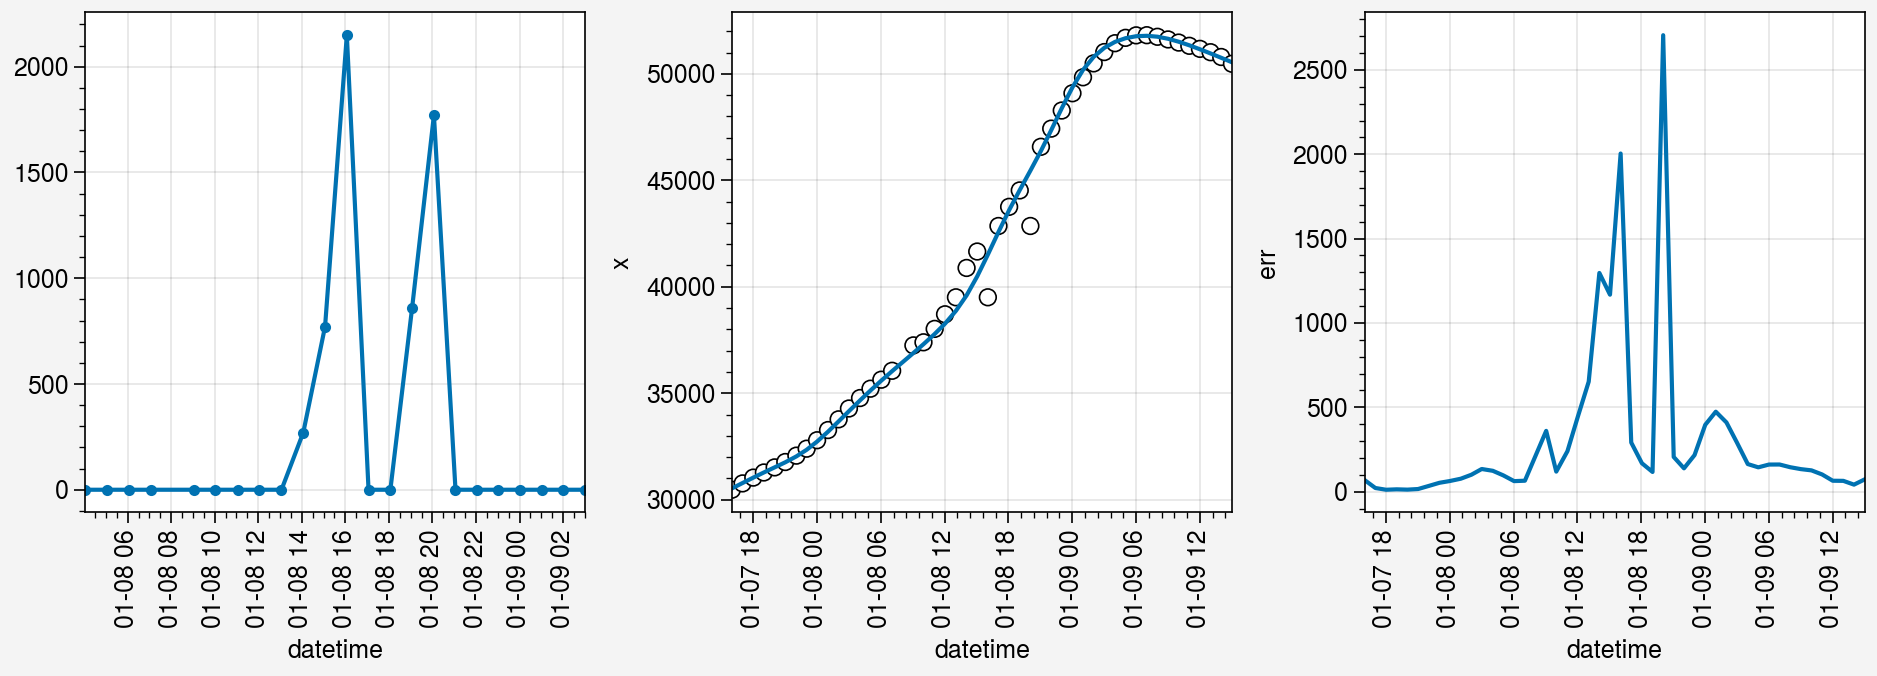

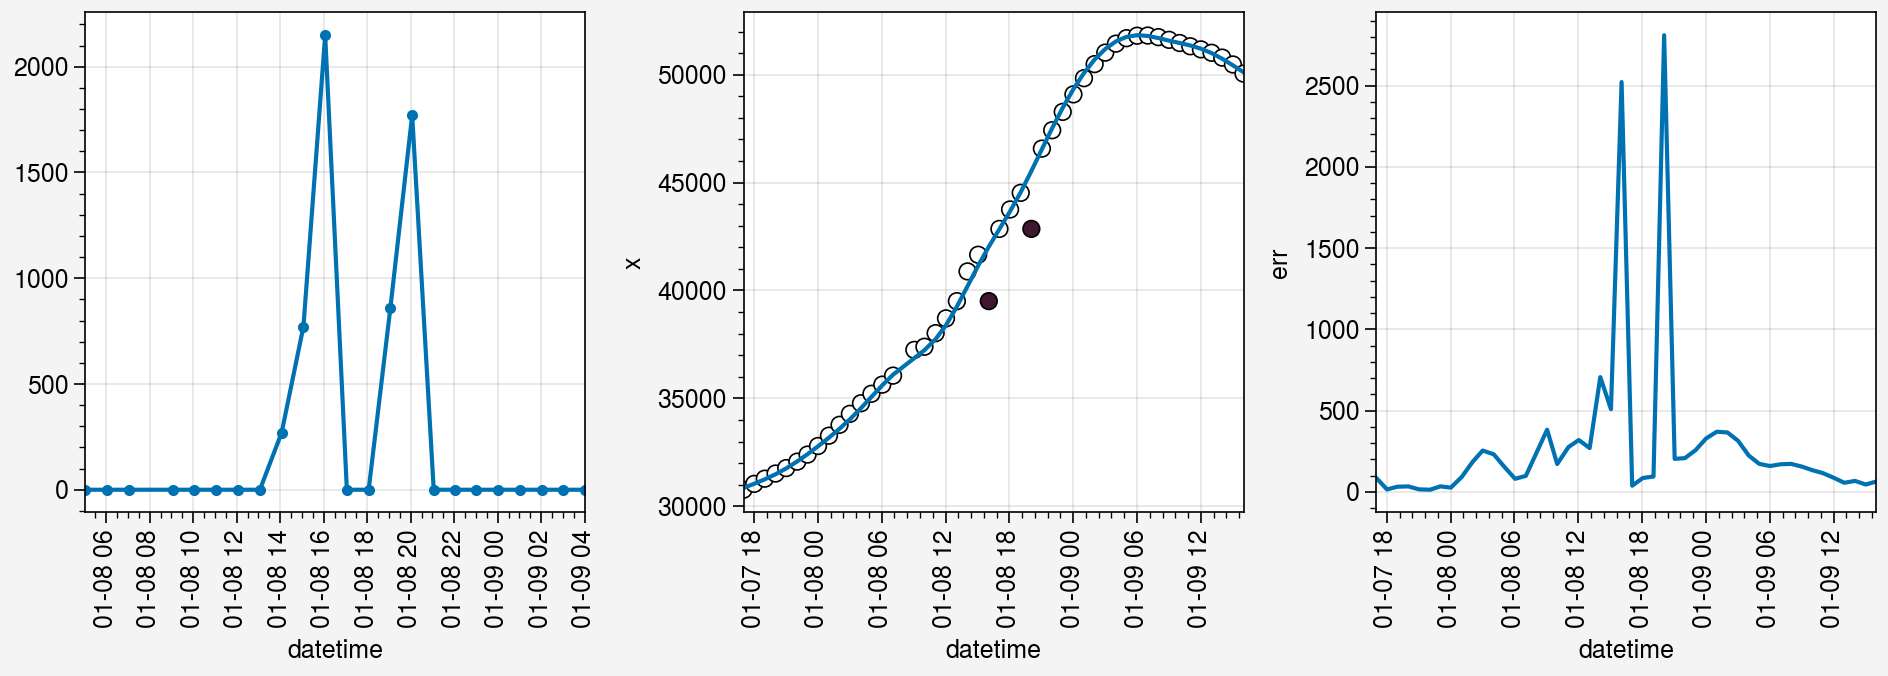

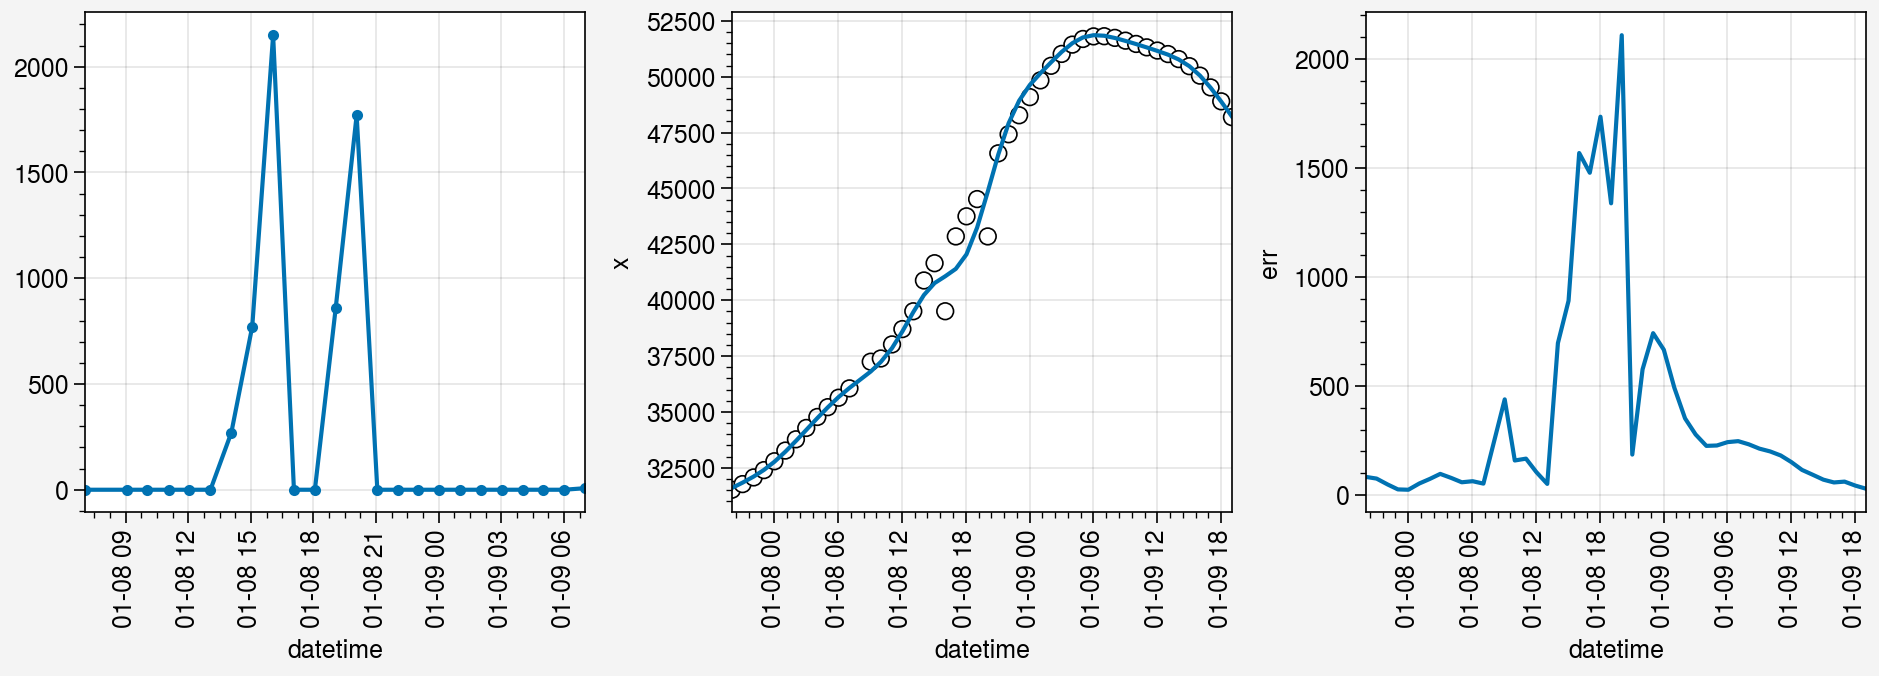

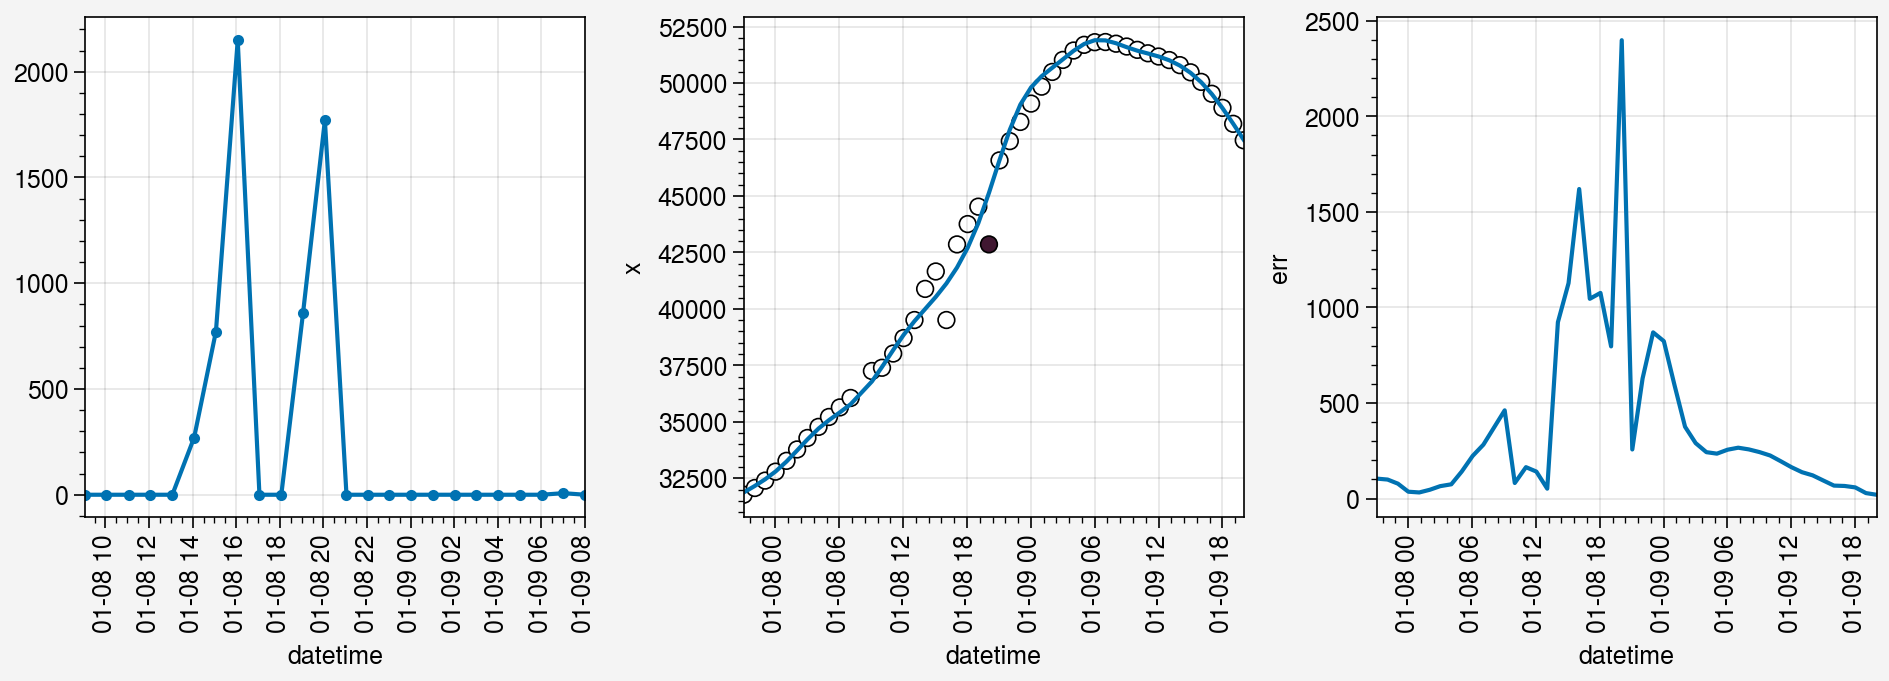

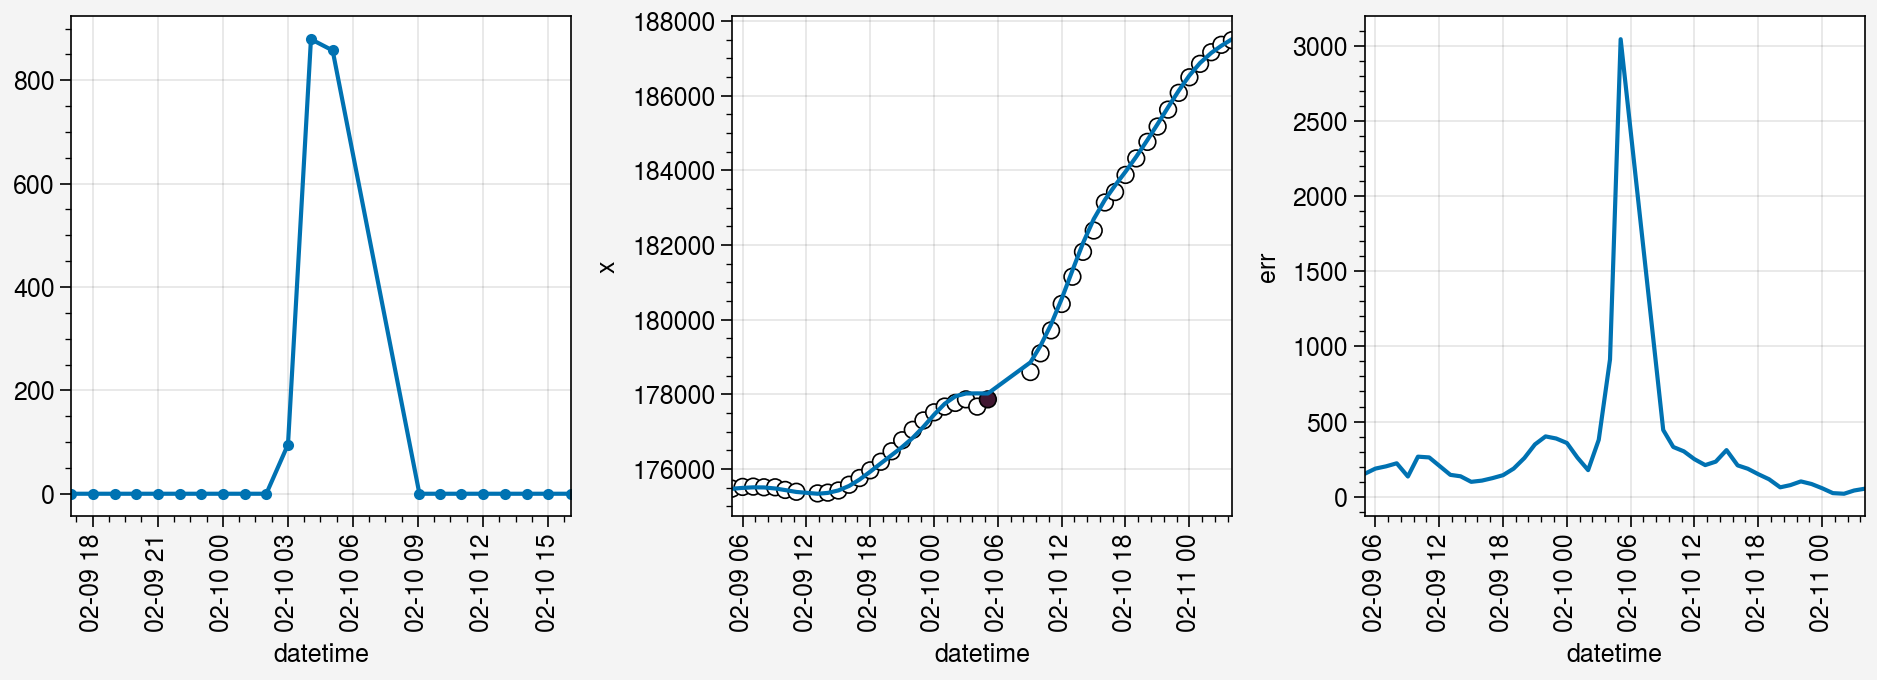

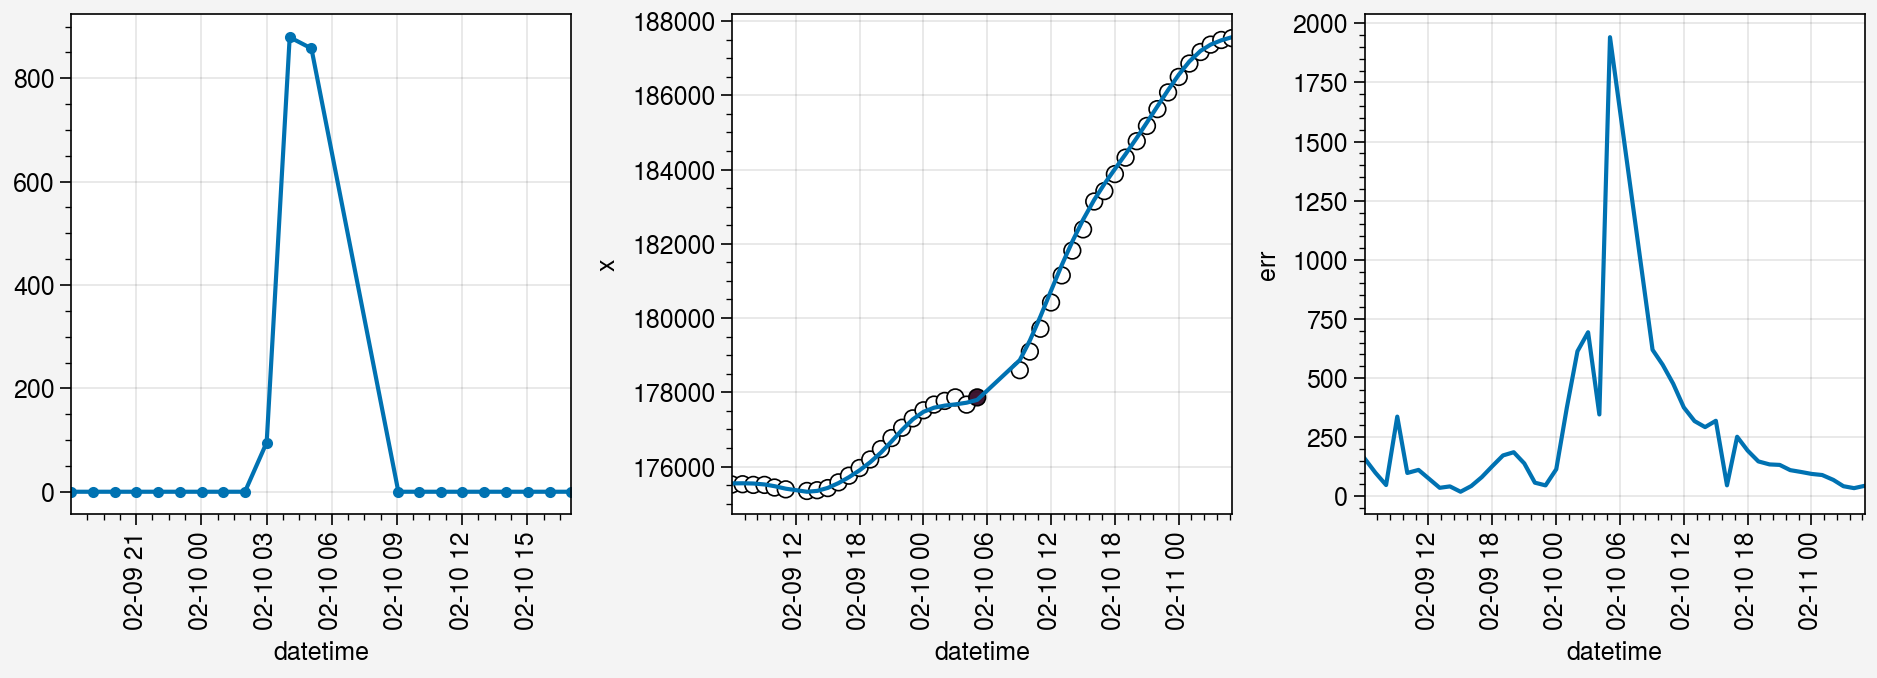

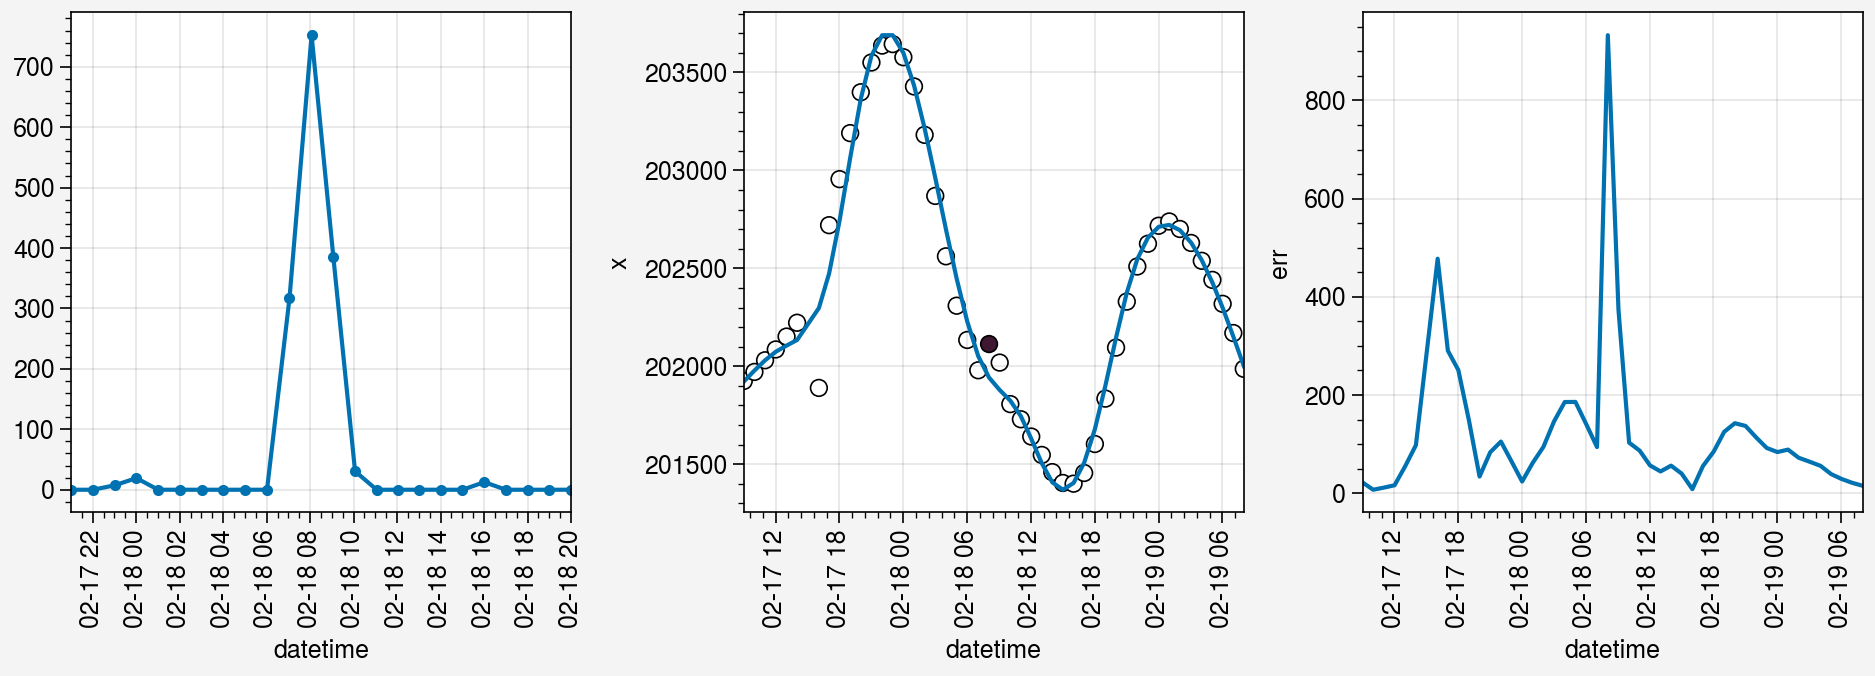

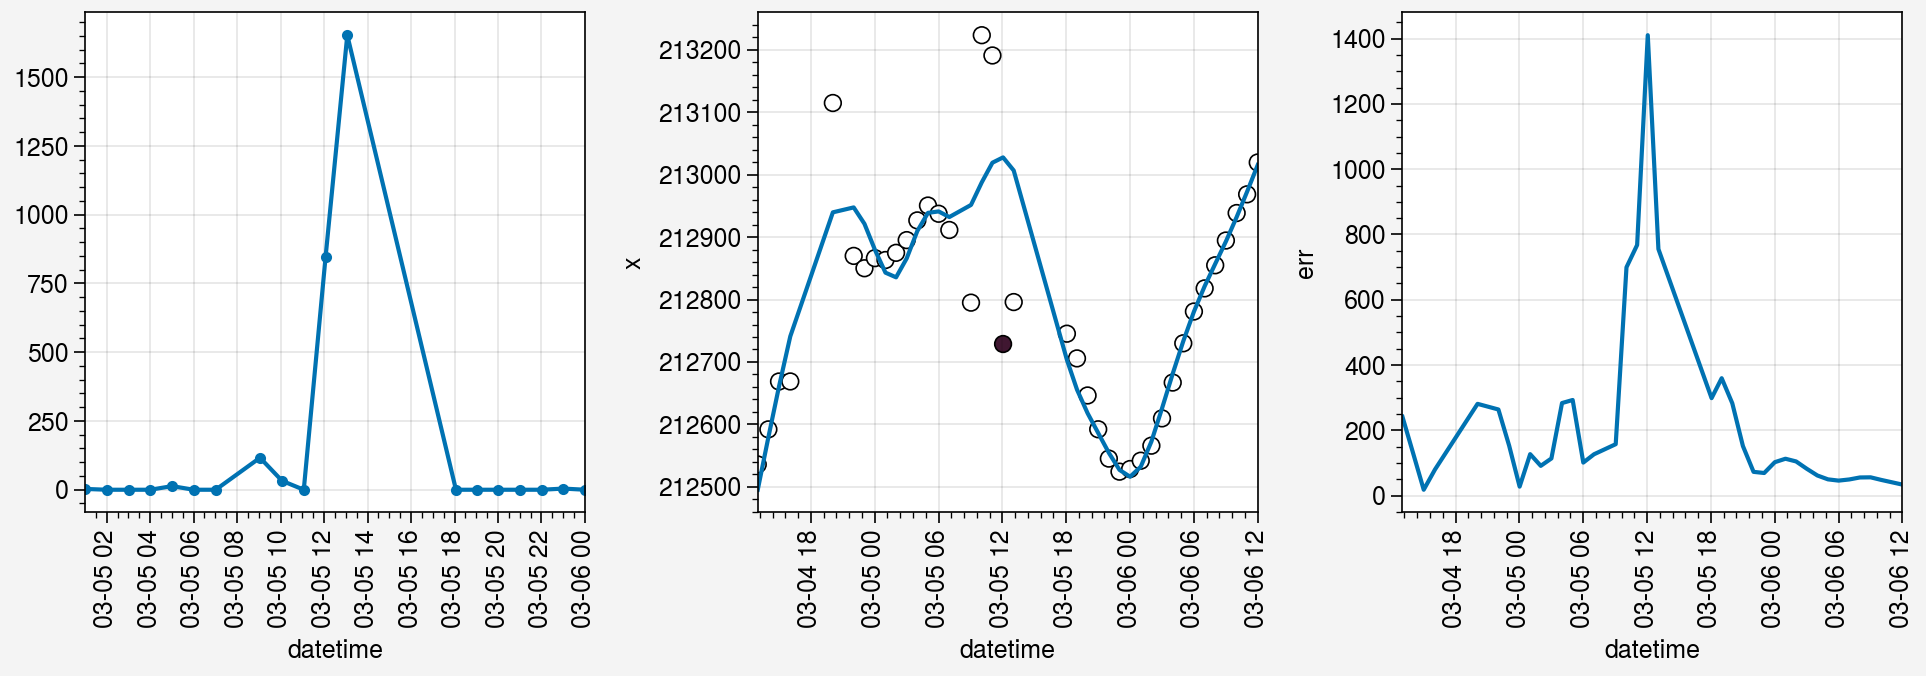

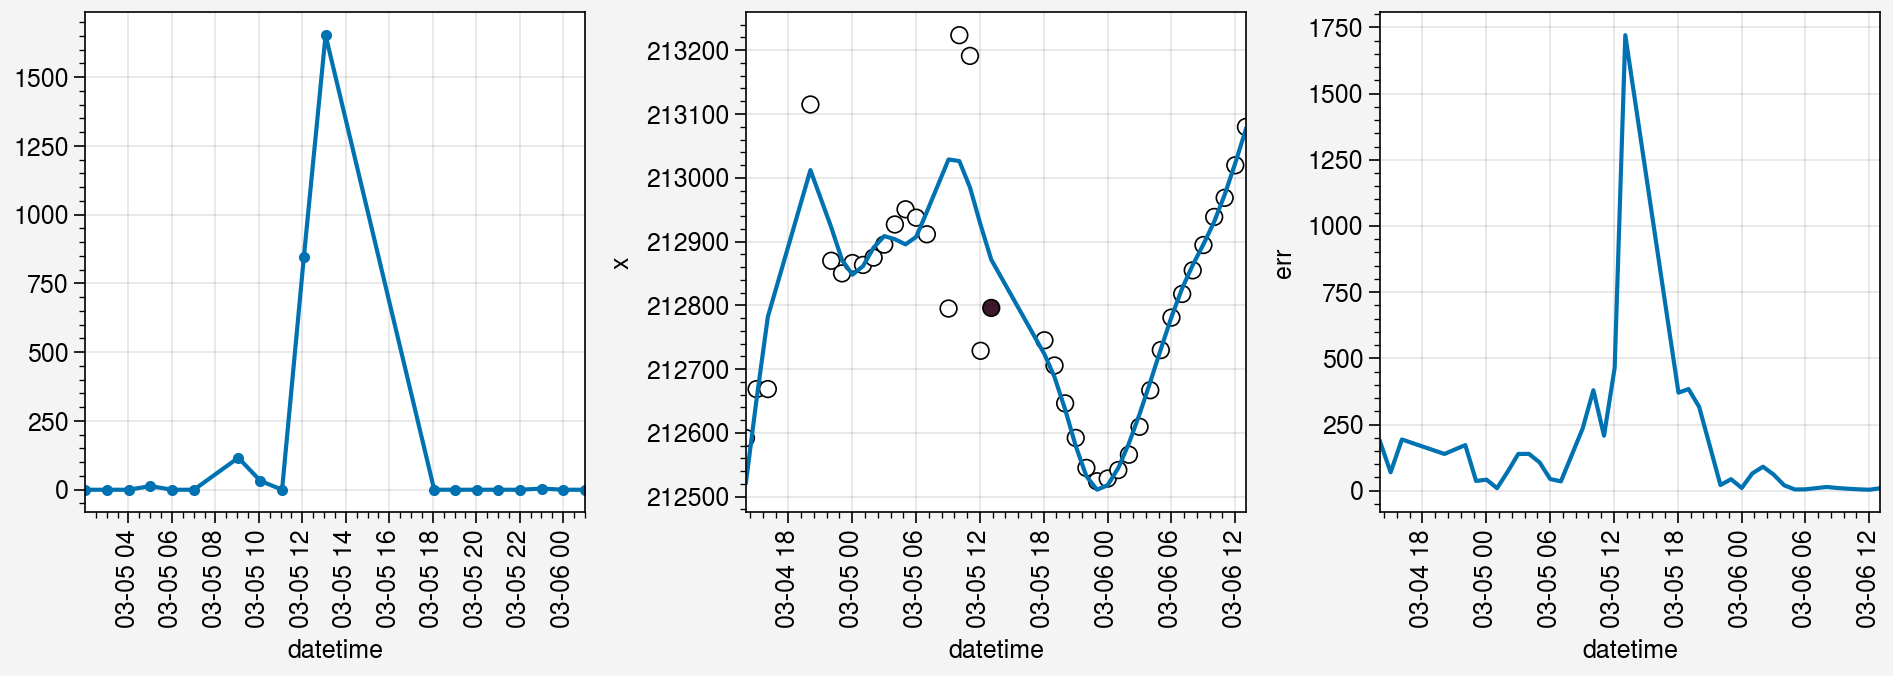

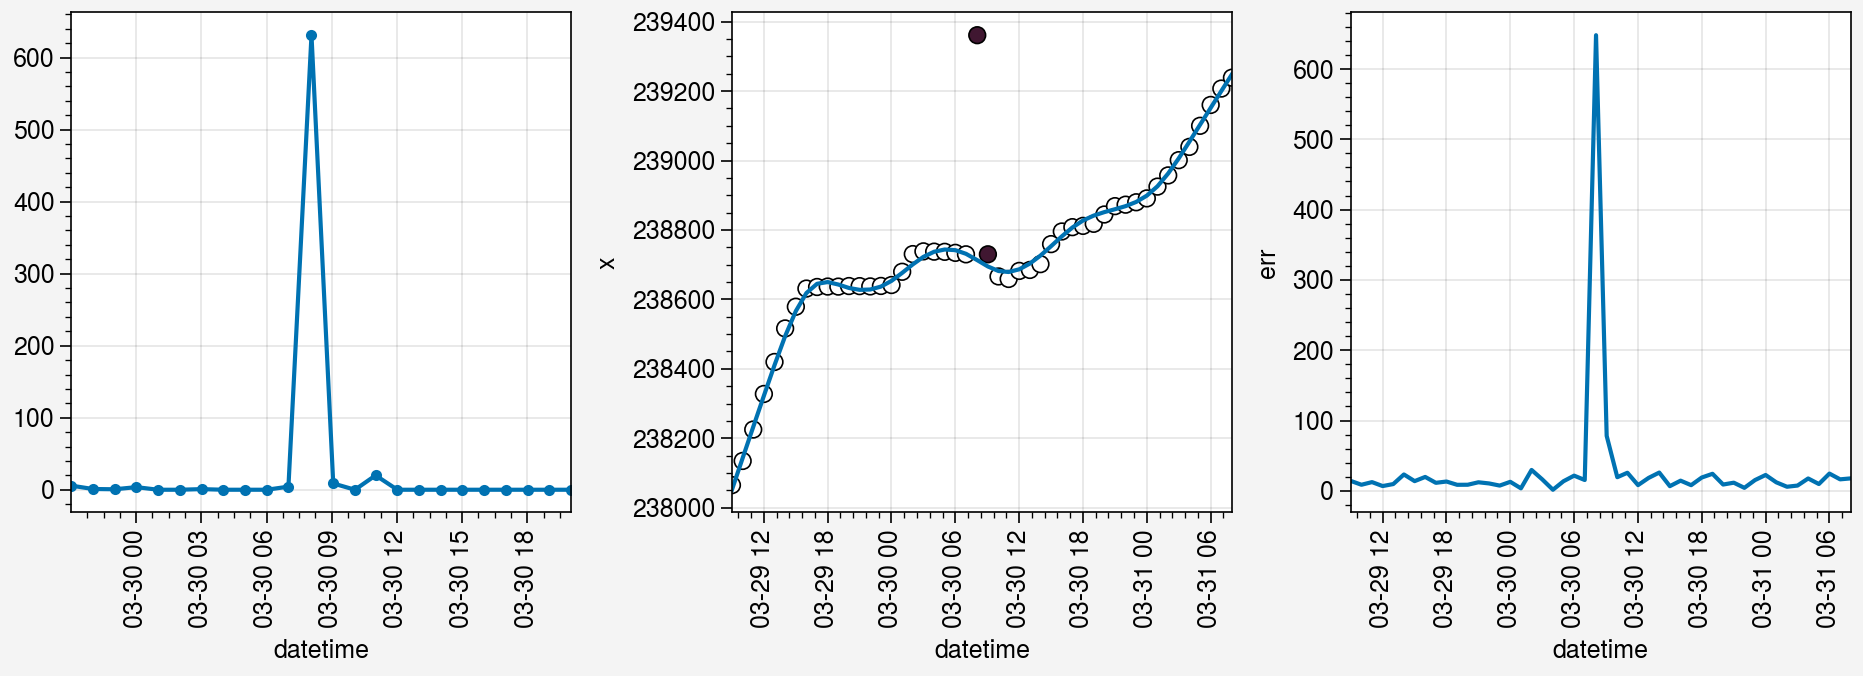

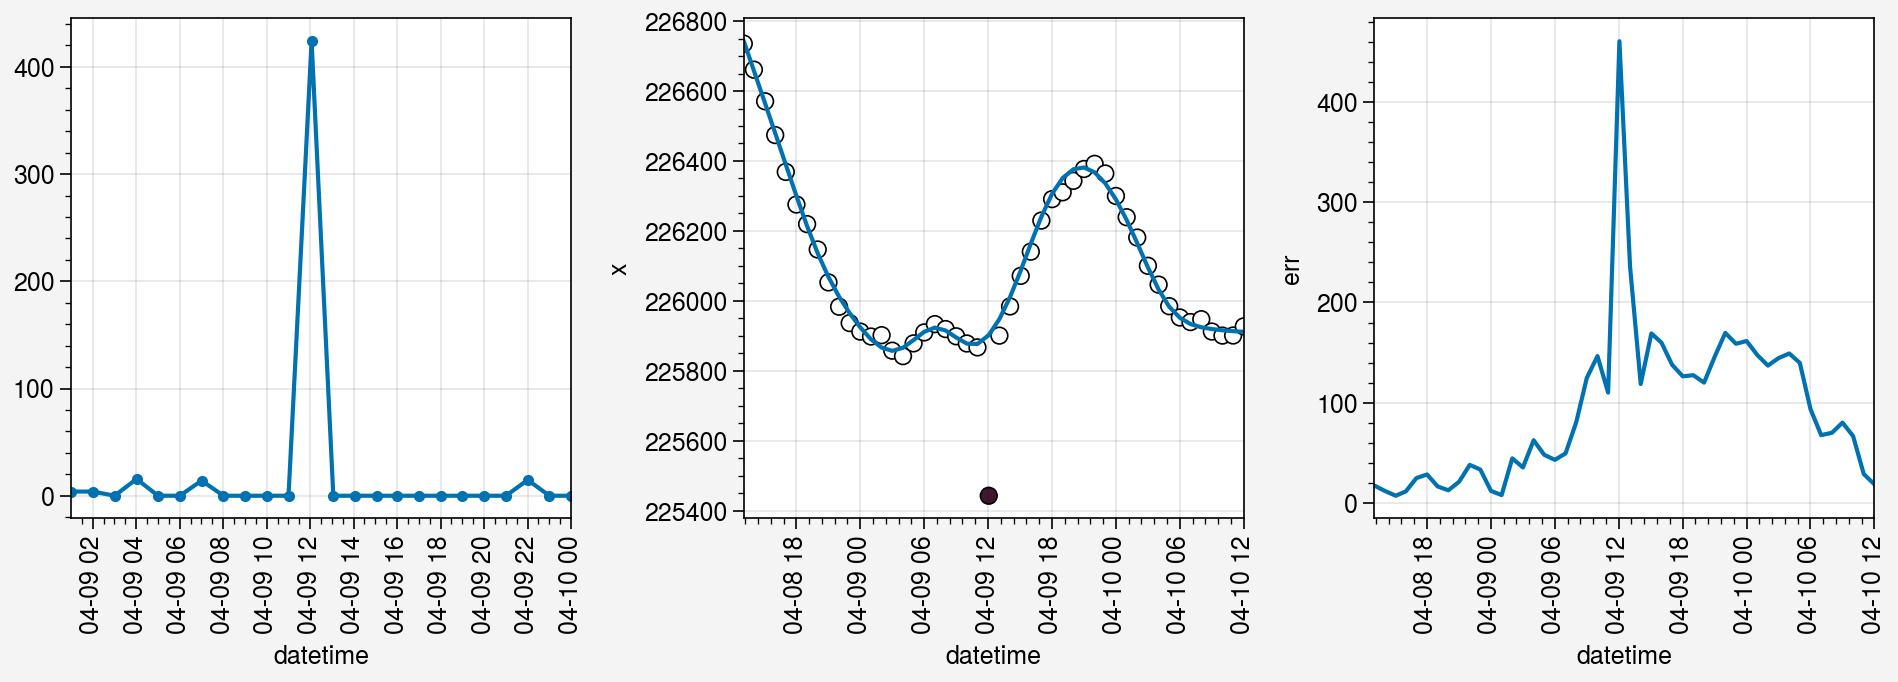

In [191]:
date = test_df.loc[2, 'date']
margin = pd.to_timedelta('12H')
buoy = test_df.loc[2, 'buoy_id']
anom_x = buoy_data[buoy].x_anom
anom_y = buoy_data[buoy].y_anom
anom = np.sqrt(anom_x**2 + anom_y**2)
buoy_data[buoy]['flag_position_spline'] = 0
print(anom[anom > 400].index)
for date in anom[anom > 400].index:
    test = clean.test_point(date, buoy_data[buoy],
                            xvar='x', yvar='y', df=13, fit_window='24H', sigma=6)
    if np.any(test.flag.notnull()):
        buoy_data[buoy].loc[test.loc[test.flag.notnull()].index, 'flag_position_spline'] = 1
                            
    fig, ax= pplt.subplots(ncols=3, share=False)
    ax[0].plot(anom.loc[slice(date-margin, date+margin)], marker='.')
    ax[1].scatter(test.x, c=test.flag.astype(int), edgecolor='k')
    ax[1].plot(test.x_hat)
    ax[2].plot(test.err)

In [41]:
fix_buoys = ['2019O3', '2019O4', '2019P102', '2019P103', '2019P105', '2019P138',
             '2019P140', '2019P142', '2019P183', '2019P203', '2019P88', '2019P91', '2019P196',
             '2019R9', '2019S96', '2019V4', '2020E3', '2020P219', '2020P220', '2020T73']
fix_buoys.sort()



In [75]:
t0 = pd.to_datetime('2019-11-01 00:00')
t = (buoy_data[buoy].index - t0).total_seconds()
x = buoy_data[buoy].longitude
y = buoy_data[buoy].latitude
# fraction used: it'd be better to have a moving window.
xhat = lowess(x, t, frac=12/len(t))

2019O3


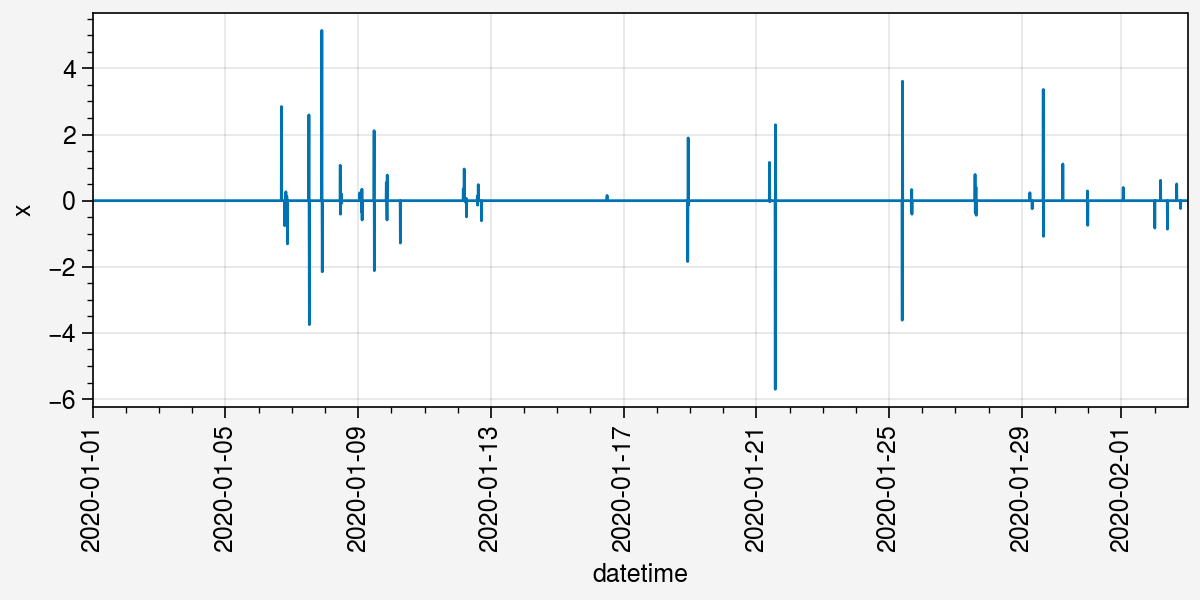

In [90]:
fig, ax = pplt.subplots(width=6, height=3)
timeslice = slice('2020-01-01', '2020-02-02')
for buoy in ['2019O3']:
    buoy_data[buoy]['flag'] = buoy_data[buoy].flag_date | buoy_data[buoy].flag_gaps
    speed = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['x']
    anomaly = speed - speed.rolling(3, center=True, min_periods=3).median()
    ax.plot(anomaly.loc[timeslice], lw=1, marker='')
    if np.any(buoy_data[buoy].loc[timeslice].speed > 0.4):
        print(buoy)
#ax.format(ylim=(0, 0.6))

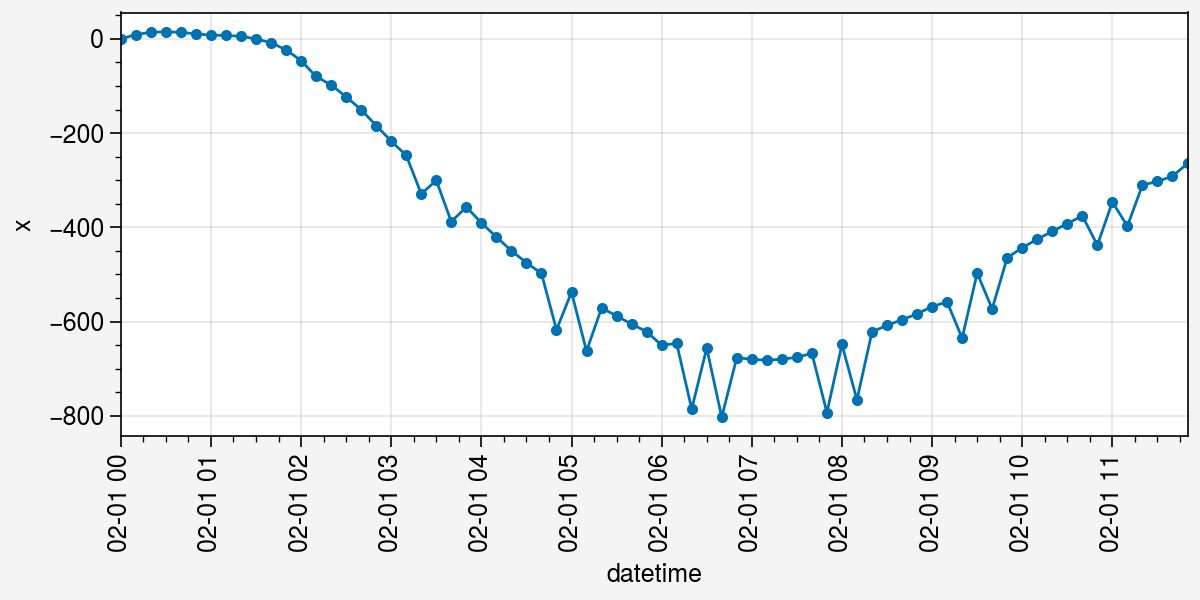

In [71]:
fig, ax = pplt.subplots(width=6, height=3)
timeslice = slice('2020-02-01', '2020-02-01 12:00')
for buoy in ['2019O3']:
    buoy_data[buoy]['flag'] = buoy_data[buoy].flag_date | buoy_data[buoy].flag_gaps
    posy = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['y'].loc[timeslice]
    posx = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['x'].loc[timeslice]    
    ax.plot(posx-posx.rolling('1H').median(), lw=1, marker='.')
#    if np.any(buoy_data[buoy].loc[timeslice].speed > 0.4):
#        print(buoy)
#ax.format(ylim=(0, 0.6))

<a list of 1 Line2D objects>

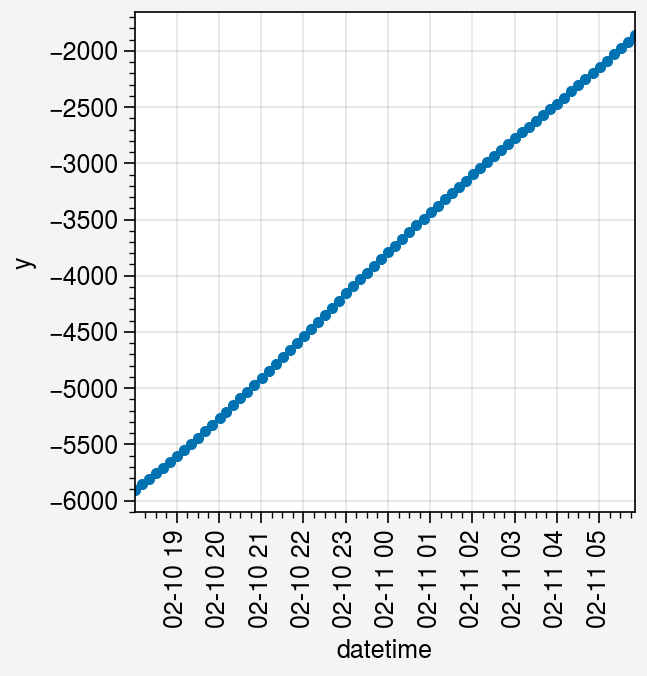

In [282]:
# Question: would interpolation with a cubic spline be faster than the check_splines method?
fig, ax = pplt.subplots()
date = pd.to_datetime('2020-02-11 00:00')
margin = pd.to_timedelta('6H')
ax.plot(#buoy_data['2019P103'].loc[slice(date-margin, date+margin)].u,
        buoy_data['2019P103'].loc[slice(date-margin, date+margin)].y, marker='.')

Removing data points with unphysical reported speeds

Problem: difficult to identify problem data points in a consistent way since the buoy data are not consistent. Tried lots of different things to clean the data, with some progress and some recurring setbacks.

Plan: One month at a time, identify buoys with clear problems

Potentially make season and latitude dependent speed thresholds
(winter: 

Potentially frequency dependent speed anomaly thresholds

In [173]:
for buoy in buoy_data:
    fwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='forward')   
    bwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='backward')
    speed = pd.DataFrame({'b': bwd_speed['speed'], 'f': fwd_speed['speed']}).min(axis=1)
    anomaly = speed - speed.rolling('1D', center=True, min_periods=6).mean()
    buoy_data[buoy]['flag_speed'] = anomaly > 1


In [196]:
for buoy in buoy_data:
    if buoy_data[buoy].flag_speed.sum() > 0:
        print(buoy, buoy_data[buoy].flag_speed.sum())

2019P105 2
2019P119 22
2019P151 1
2019P203 1
2019P206 1
2019R9 1
2019T70 1
2019V4 1
2020O10 7
2020P218 1
2020P225 1


In [197]:
timeslice=slice('2021-02-01', '2021-05-01')
buoy = '2019P105'


In [193]:
flagged

DatetimeIndex(['2019-12-01 15:13:59', '2019-12-06 07:10:36'], dtype='datetime64[ns]', name='datetime', freq=None)

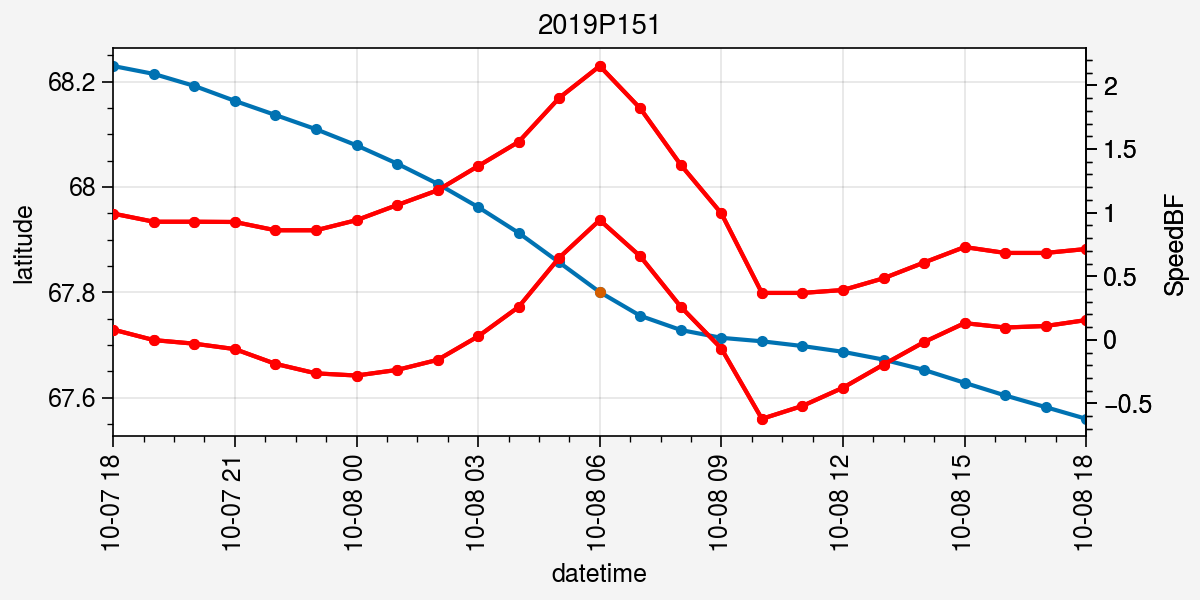

In [205]:
buoy = '2019P151'
margin = pd.to_timedelta('12H')
buoy_df = buoy_data[buoy].copy()
fwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='forward')   
bwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='backward')
speed = pd.DataFrame({'b': bwd_speed['speed'], 'f': fwd_speed['speed']}).min(axis=1)
anomaly = speed - speed.rolling('12H', center=True, min_periods=6).mean()

flagged = buoy_df.loc[(buoy_df.flag_speed==1)].index
if len(flagged) == 1:
    date = pd.to_datetime(flagged[0])
else:
    date = pd.to_datetime(flagged[1])

fig, ax = pplt.subplots(width=6, height=3)

buoy_df = buoy_df.loc[slice(date-margin, date+margin)]
threshold = buoy_df.rolling('12H', center=True).latitude.count()
ax.plot(buoy_df.latitude, marker='.')
ax.plot(buoy_df.where(buoy_df.flag_speed==1).latitude, marker='.', lw=0)
ax.format(title=buoy)

ax2 = ax.twinx()
ax2.plot(anomaly.loc[slice(date-margin, date+margin)], color='r', marker='.')
ax2.plot(speed.loc[slice(date-margin, date+margin)], color='r', marker='.')


ax2.format(ylabel='SpeedBF')

In [206]:

# Step one: compute dist_from_median_uv, dist_from_median_xy, distance to closest point
for buoy in buoy_data:
    data = buoy_data[buoy]
    fwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='forward')   
    bwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='backward')
    speed = pd.DataFrame({'b': bwd_speed['speed'], 'f': fwd_speed['speed']}).min(axis=1)
    u = pd.DataFrame({'b': np.abs(bwd_speed['u']), 'f': np.abs(fwd_speed['u'])}).min(axis=1)
    v = pd.DataFrame({'b': np.abs(bwd_speed['v']), 'f': np.abs(fwd_speed['v'])}).min(axis=1)    
    buoy_data[buoy]['speed_bf'] = speed
    buoy_data[buoy]['x'] = fwd_speed['x']
    buoy_data[buoy]['y'] = fwd_speed['y']

    check_dup = clean.flag_duplicates(data, date_index=True)
    check_dates = clean.check_dates(data, date_index=True)
    check_speed = clean.check_speed(data, date_index=True, sigma=10, window=5)

    flags = (check_dup | check_dates) | check_speed
    
    data = data.where(~flags).dropna()
    
    # Add check with the spline function
    
    if len(data.loc[slice(begin, end)]) > 30*24:        
        dt = pd.to_timedelta(np.diff(data.index)).median().seconds/3600
        if np.round(dt,1) <= max_dt:
            data_interp = interp.interpolate_buoy_track(
                data.loc[slice(pd.to_datetime(begin)-margin,
                               pd.to_datetime(end)+margin)],
                xvar='longitude', yvar='latitude', freq='1H',
                maxgap_minutes=240)
            data_interp['day_count'] = data_interp.rolling(window='1D', center=True).count()['longitude']
            data_interp = data_interp.where(data_interp.day_count >= 12).dropna()
                
            # Compute speed with interpolated data
            data_interp = clean.compute_speed(
                data_interp, date_index=True, rotate_uv=True, difference='centered').loc[slice(begin, end)]
            
            # Write to file
            data_interp.to_csv(saveloc + metadata.loc[buoy, 'filename'] + '.csv')
            
        else:
            print(buoy, dt, 'Frequency too low')
    else:
        print(buoy, 'Insufficient data after dup/date/speed check: ', len(data))

KeyboardInterrupt: 